## Tune Vetting metrics in Exovetter

Create a small sample of known false positives and known true positives to tune your exovetter thresholds.
Especially for SWEET and LPP and Modshift and Centroid.
then see what is left.
I'd say pick 100 unique searches randomly from the bright uncrowded set.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import parmap  #This code lets me speed things up by doing archive callsin parallel
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Using qlp
notransit_file = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tcesum.csv"
planet_file = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/second-dataset/qlp_ebplanets_tcesum.csv"
col_names = ["tic","pn","sector","period","epoch","depth","dur","snr","disp","reason", "match"]
notransit_df = pd.read_csv(notransit_file, names=col_names)
planet_df = pd.read_csv(planet_file, names=col_names)

#Created using uncrowded_kepler_targets.py
targetdf = pd.read_csv("/Users/smullally/Science/tess_false_alarms/keplerTargets/target_selection/target_tic_contamination_20210528.txt")
print(len(targetdf))
targetdf = targetdf.drop_duplicates(subset=['ticid','sector', 'Tmag'])
print(len(targetdf))

#Uniqueid
notransit_df['uniqueid'] = list(map( lambda x, y : "%s-s%u" % (x, y), notransit_df['tic'], notransit_df['sector']))
planet_df['uniqueid'] = list(map( lambda x, y : "%s-s%u" % (x, y), planet_df['tic'], planet_df['sector']))
targetdf['uniqueid'] = list(map( lambda x, y : "TIC %s-s%u" % (x, y), targetdf['ticid'], targetdf['sector']))

#Merge target information into qlp TCEs.
notransit_tces = pd.merge(notransit_df, targetdf[['Tmag', 'Hmag', 'Vmag','contratio','aperture','uniqueid']], left_on="uniqueid", right_on="uniqueid", how="inner" )
planet_tces = pd.merge(planet_df, targetdf[['Tmag', 'Hmag', 'Vmag','contratio','aperture','uniqueid']], left_on="uniqueid", right_on="uniqueid", how="inner" )


84989
84614


In [3]:
print(len(notransit_df), len(notransit_tces), len(targetdf))
print(len(np.unique(targetdf['uniqueid'])))
print(len(planet_df), len(planet_tces))
print(len(np.unique(notransit_df['uniqueid'])), len(np.unique(notransit_tces['uniqueid'])))

112559 112559 84614
84614
6977 465
84058 84058


In [4]:
planet_tces[0:5]

,tic,pn,sector,period,epoch,depth,dur,snr,disp,reason,match,uniqueid,Tmag,Hmag,Vmag,contratio,aperture
0,TIC 120103486,1,14,0.8367,1683.7704,342.494,14.0,0.26,FAIL,-LowSNR--NormLPP-,NaN,TIC 120103486-s14,12.2136,11.162,12.810,0.051763,29.503800
1,TIC 120103486,1,26,1.1253,2011.1130,322.458,14.0,0.24,FAIL,-LowSNR--NormLPP-,NaN,TIC 120103486-s26,12.2136,11.162,12.810,0.051763,29.503800
2,TIC 120251825,1,14,1.5098,1683.7183,748209.592,2.0,3.60,FAIL,-NormLPP--SWEETHalfPeriod-SWEETAtPeriod,NaN,TIC 120251825-s14,12.9390,12.464,13.822,1.041497,17.093791
3,TIC 120251825,2,14,1.5098,1684.4683,767513.015,2.0,7.03,FAIL,-NormLPP--SWEETHalfPeriod-SWEETAtPeriod,NaN,TIC 120251825-s14,12.9390,12.464,13.822,1.041497,17.093791
4,TIC 120251825,3,14,1.5091,1683.7183,278923.956,4.0,3.52,FAIL,-NormLPP--SWEETHalfPeriod-SWEETAtPeriod,NaN,TIC 120251825-s14,12.9390,12.464,13.822,1.041497,17.093791


In [5]:
#Vetting code to create a light curve and then vet.

import exovetter.vetters as vet
import corazon as crz
import lightkurve as lk
from exovetter.tce import Tce
from exovetter import const 

def get_lk(tcedf, author = "qlp", mission = "TESS", size = 11):
    """Returns lc and tpf given a dataframe line"""
    
    ticid = tcedf['tic'][4:]
    sector = tcedf['sector']
    
    lc = crz.gen_lightcurve.hlsp(ticid, sector, author=author)
    tpf = lk.search_tesscut(f"TIC {ticid}", sector = sector).download(cutout_size = size)
    
    return lc, tpf

def make_tce(adf, offset = 0 * u.day):
    
    atce = Tce(period = adf['period'] * u.day,
               epoch = adf['epoch'] *u.day,
               epoch_offset = offset,
               duration=adf['dur'] * u.hr, 
               depth=adf['depth'] * const.ppm,
               snr = adf['snr'])
    
    return atce

def vet_tce(tce, lc, tpf, plot=False):
    """Pull up plots of the full and folded light curve.
        There are all plot from exovetter
    """
    
    results = []
    
    tc = vet.TransitPhaseCoverage()
    tpc = tc.run(tce,lc)
    results.append(tpc)
    
    lpp = vet.Lpp()
    lppvet = lpp.run(tce,lc)
    results.append(lppvet)
    
    try:
        mod = vet.ModShift()
        modshift = mod.run(tce, lc)
        if plot:
            modshift.plot()
        results.append(modshift)
    except:
        pass
    
    sweet = vet.Sweet()
    sweetvet = sweet.run(tce,lc)
    if plot:
        sweet.plot()
    results.append(sweetvet)
    cent = vet.Centroid()
    centout = cent.run(tce, tpf, plot=plot)
    results.append(centout)
    
    #oe = vet.OddEven()
    #oddeven = oe.run(tce,lc)
    #oe.plot()
    #results.append(oddeven)
    
    fold = vet.VizTransits(smooth=8, max_transits=5, transit_only=True)
    ntransits = fold.run(tce, lc, plot=plot)
    results.append(ntransits)
    
    
    return results

In [9]:
#Get N tces at random for testing
r = np.random.randint(0, len(notransit_tces), size = 5)
notransit_samp = notransit_tces.iloc[r]



In [10]:
def vet_get_results(tcedfrow, plot=False, offset=const.btjd):
    tcedf = tcedfrow[1]
    alc, atpf = get_lk(tcedf) 
    atce = make_tce(tcedf, offset=offset)
    results = vet_tce(atce, alc, atpf, plot=plot)
    
    tcevet = dict(tcedf)
    for r in results:
        for k in r.keys():
            if k[0:3] != "plo":  #Don't include plot data
                tcevet[k] = r[k]
    
    return tcevet


In [ ]:
result = parmap.parmap(vet_get_results, notransit_samp.iterrows(),engine='threads')



[▶··················································································································] 0/5 (0 sec) 


In [93]:
result[1]

{'tic': 'TIC 164461137',
 'pn': 5,
 'sector': 26,
 'period': 4.2099,
 'epoch': 2012.1753,
 'depth': 15128.621,
 'dur': 1.0,
 'snr': 4.34,
 'disp': ' FAIL',
 'reason': ' -NormLPP--OddEvenDetected-',
 'match': nan,
 'uniqueid': 'TIC 164461137-s26',
 'Tmag': 11.6168,
 'Hmag': 9.616,
 'Vmag': 12.841,
 'contratio': nan,
 'aperture': 34.08674149023658,
 'transit_phase_coverage': 0.6,
 'raw_lpp': 0.0073366644726370524,
 'norm_lpp': 13.433389480735595,
 'pri': 128,
 'phase_pri': 1.333829702970297,
 'sec': 117,
 'phase_sec': 1.2254560396039604,
 'ter': 280,
 'phase_ter': 2.7135098019801984,
 'pos': 23,
 'phase_pos': 0.24592485148514853,
 'sigma_pri': -525.0734197234093,
 'sigma_sec': -514.5182333908285,
 'sigma_ter': -394.5412359243955,
 'sigma_pos': 248.86396171803548,
 'false_alarm_threshold': 2.5793966979613265,
 'Fred': 89.15891891841193,
 'msg': 'OK: SWEET finds no out-of-transit variability at transit period',
 'amp': array([[1.86894871e-04, 4.06739722e-04, 4.59495006e-01],
        [7.518

In [95]:
new = list(filter(lambda x : x is not None, result))
vetted = pd.DataFrame(new)
vetted

,tic,pn,sector,period,epoch,depth,dur,snr,disp,reason,...,sigma_sec,sigma_ter,sigma_pos,false_alarm_threshold,Fred,msg,amp,offset,significance,num_transits
0,TIC 164461137,5,26,4.2099,2012.1753,15128.621,1.0,4.34,FAIL,-NormLPP--OddEvenDetected-,...,-514.518233,-394.541236,248.863962,2.579397,89.158919,OK: SWEET finds no out-of-transit variability ...,"[[0.0001868948713819144, 0.000406739722416632,...",1.427752,[0.9601267194386653],6
1,TIC 269357468,1,15,1.2439,1711.8097,877.586,12.0,0.28,FAIL,-LowSNR--NormLPP-,...,61.812474,61.812474,NaN,0.838123,3.876176,OK: SWEET finds no out-of-transit variability ...,"[[0.00040348792605411155, 0.000258146727013416...",0.636482,[0.9863138483806643],22
2,TIC 270957565,4,14,5.6952,1685.0511,9030.911,1.0,1.65,FAIL,-NormLPP-,...,-305.082153,-304.651913,481.011970,2.682103,101.849547,WARN: SWEET test finds signal at HALF transit ...,"[[0.0015772973193587947, 0.000318218980125741,...",1.475893,[0.5884293841529711],4
3,TIC 158494625,1,14,0.8316,1683.6785,376.857,14.0,0.32,FAIL,-LowSNR--NormLPP-,...,NaN,NaN,NaN,NaN,NaN,OK: SWEET finds no out-of-transit variability ...,"[[0.00014424940443777203, 0.000126880379398930...",2.661144,[0.7827872909884903],34
4,TIC 405688870,1,14,2.4067,1685.4454,761.018,1.0,1.38,FAIL,-NormLPP-,...,-291.656187,-253.262406,139.584580,2.379997,66.765563,WARN: SWEET test finds signal at TWICE the tra...,"[[1.835194499491407e-05, 3.4987395764499944e-0...",0.277643,[0.9255633288773347],11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,TIC 268932656,1,14,0.9014,1683.9050,727.418,14.0,0.26,FAIL,-LowSNR--NormLPP-,...,NaN,NaN,NaN,NaN,NaN,OK: SWEET finds no out-of-transit variability ...,"[[0.00014740180585191473, 0.000288924984105901...",0.864394,[0.9652535894835147],31
67,TIC 121939473,3,14,0.9145,1683.6971,770.877,14.0,0.33,FAIL,-LowSNR--NormLPP-,...,NaN,NaN,NaN,NaN,NaN,WARN: SWEET test finds signal at TWICE the tra...,"[[0.0016161219427288868, 0.0013746315783784108...",1.326393,[0.8387297323928226],31
68,TIC 27082218,1,14,0.9594,1683.6929,445.730,14.0,0.74,FAIL,-LowSNR--NormLPP--SWEETHalfPeriod-SWEETAtPeriod,...,NaN,NaN,NaN,NaN,NaN,WARN: SWEET test finds signal at HALF transit ...,"[[0.0006739524913249718, 0.0001170288889957843...",0.718276,[0.8178328385075626],29
69,TIC 121461494,1,14,10.3153,1692.3826,8307.980,1.0,2.95,PASS,,...,-160.101165,-155.723989,180.860696,2.875076,52.026458,WARN: SWEET test finds signal at the transit p...,"[[0.0003795738389467141, 0.0001486431855320705...",0.542055,[nan],2


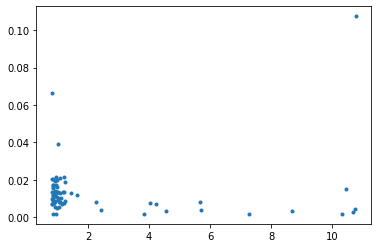

In [108]:
import matplotlib.pyplot as plt

plt.plot(vetted['period'],vetted['raw_lpp'], '.')


